# Comparison of GPyTorch and GAUCHE Libraries
_Drew Gjerstad, University of Minnesota_

## Introduction

[GPyTorch](https://gpytorch.ai) is a Python library that contains a highly
efficient and modular implementation of Gaussian processes (GPs) with GPU
acceleration in PyTorch, a popular deep learning framework. Gaussian processes
can be used to form surrogate models within the Bayesian optimization paradigm.
However, sometimes we wish to build these surrogate models based on data with
irregular representations such as graph-based data. This is where the
[GAUCHE](https://github.com/leojklarner/gauche) library becomes attractive. The
GAUCHE package was originally designed for building Gaussian processes and
performing Bayesian optimization on molecular representations. However, it can
be used to build Gaussian processes for graph-based data in general.

### Installing GPyTorch
To install `gpytorch`, run the following cell. Alternatively, run this command
in your terminal: `pip install gpytorch`. Note that this requires Python version
3.8 or higher.

In [ ]:
%pip install gpytorch

### Installing GAUCHE
To install `gauche`, run the following cell. Alternatively, run this command in
your terminal: `pip install gauche`. Note that this requires Python version 3.9
or higher and additional installation options are available at the
[gauche GitHub repository](https://github.com/leojklarner/gauche).

In [ ]:
%pip install gauche

## GPyTorch Implementation

Before we begin examining the implementation of the GPyTorch library, the
documentation for the entire library in addition to examples (some of which will
be featured in this notebook) can be found here:
[GPyTorch docs](https://docs.gpytorch.ai/en/stable/). First, we will examine the
different components that make up the "anatomy" of the library.

 * `gpytorch.models` contains various models that will handle the inference.
 * `gpytorch.likelihoods` contains multiple likelihood functions.
 * `gpytorch.means` contains several different prior means for the GP.
 * `gpytorch.kernels` contains different kernels used to determine the prior
    covariance of the GP.
 * `gpytorch.distributions` contains representations of different distributions.

These are the primary modules that are used to develop a Gaussian process. There
are a few other modules within the GPyTorch library but for the purposes of this
comparison these are the ones we will focus on.

### Basic Usage
In this section, we will develop a basic GPyTorch model and use it to make
predictions. This is based on the
[Simple GPyTorch Regression Tutorial](https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html) that demonstrates how to train an RBF kernel Gaussian
process on a simple function. The function that is modeled is given by

$$y = \sin(2\pi x) + \epsilon$$

$$\epsilon \sim \mathcal{N}(0, 0.04)$$

In [1]:
# Load Dependencies
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

In [35]:
# Initialize Training Data
train_x = torch.linspace(0, 1, 100)  # 100 training points, evenly spaced
train_y = (torch.sin(train_x * (2 * math.pi)) + 
           torch.randn(train_x.size()) * math.sqrt(0.04))  # true function y

In the setup below, the way models are specified in GPyTorch enables flexibility
when it comes to defining a model. As shown below, if we want to compose two
kernels via addition this can either be done directly in the `__init__` method
or the outputs of each kernel can be added in the `forward` method.

`self.covar_module = ScaleKernel(RBFKernel() + LinearKernel())`

`covar_x = self.rbf_kernel_module(x) + self.white_noise_module(x)`

In [13]:
# Set Up Model (simplest form -> exact inference)
from gpytorch.models import ExactGP
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal

class ExactGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        """
        This method takes the training data and likelihood to construct any
        objects which are needed for the model's `forward` method. Typically,
        this includes objects such as a mean module and a kernel module.
        """
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        """
        This method takes in some data, `x`, with shape (n, d) and returns a
        `MultivariateNormal` with the prior mean and covariance evaluated at
        `x`. Simply put, this method returns the vector mu(x) and the n-by-n
        matrix K_{xx} which represents the prior mean and covariance matrix of
        the Gaussian process, respectively.
        """
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [14]:
# Initialize Likelihood and Model
likelihood = GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

Just like in PyTorch, the models in GPyTorch also have different modes for
training and evaluation: `.train()` and `.eval()`, respectively. The training
mode is used for optimizing model hyperparameters and the evaluation mode is
for computing predictions via the model posterior.

One notable difference when compared to other Gaussian process libraries, as is
standard practice in PyTorch, the training loop is defined by the user. In
addition, in GPyTorch, we utilize standard PyTorch optimizers from `torch.optim`
where all trainable parameters should have type `torch.nn.Parameter`. Finally,
since the GP models defined by GPyTorch extend `torch.nn.Module`, function calls
to `model.parameters()` and `model.named_parameters()` function as one would
expect in standard PyTorch.

The training loop defined below has the same components as a standard PyTorch
training loop:
1. Zero all parameter gradients.
2. Call the model, compute the loss.
3. Call backward on the loss to fill in gradients.
4. Take a step on the optimizer.

An advantage of GPyTorch over other GP libraries is that being able to directly
define the training loop allows for increased flexibility. For example, we are
able to save the parameters at each step of training (useful for keeping track
of the best model at different steps in the optimization process), or use
different learning rates for different parameters (useful for deep kernel
learning).

In [16]:
# Run Notebook in Testing Framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

# Set Model and Likelihood to Training Mode
model.train()
likelihood.train()

# Initialize Adam Optimizer (used to find optimal hyperparameters)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Define the "Loss" for GPs (the marginal log-likelihood)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Define Training Loop
for i in range(training_iter):
    # (1) Zero gradients from previous iteration.
    optimizer.zero_grad()

    # (2) Call the model, compute the loss.
    output = model(train_x)
    loss = -mll(output, train_y)

    # (3) Call backward on the loss to fill in gradients.
    loss.backward()

    # Print Info (every 10 iterations to reduce output)
    if (i + 1) % 10 == 0:
        print('Iteration %d/%d - Loss: %.3f    lengthscale: %.3f    noise: %.3f'
               % (i + 1, training_iter, loss.item(),
                  model.covar_module.base_kernel.lengthscale.item(),
                  model.likelihood.noise.item()
                 )
        )

    # (4) Take a step on the optimizer.
    optimizer.step()

Iteration 10/50 - Loss: -0.064    lengthscale: 0.262    noise: 0.037
Iteration 20/50 - Loss: -0.064    lengthscale: 0.257    noise: 0.041
Iteration 30/50 - Loss: -0.064    lengthscale: 0.259    noise: 0.039
Iteration 40/50 - Loss: -0.064    lengthscale: 0.260    noise: 0.038
Iteration 50/50 - Loss: -0.064    lengthscale: 0.258    noise: 0.039


Once the model is trained, we can use it to make predictions. If we denote a
test point (`test_x`) as `x*` with the true output being `y*`, then
`model(test_x)` will return the model posterior distribution `p(f* | x*, X, y)`,
for training data `X`, `y`. This distribution is the posterior over the function
that we are trying to model, quantifying our model uncertainty.

On the other hand, `likelihood(model(test_x))` provides the posterior
predictive distribution `p(y* | x*, X, y)` which is the probability distribution
over the predicted output value. Therefore, obtaining the predictive mean and
variance, and then sampling from the Gaussian process at the given test points
can be accomplished using the calls in the next code cell below.

In [34]:
# Initialize Testing Data
test_x = torch.linspace(0, 1, 51)
test_y = (torch.sin(test_x * (2 * math.pi)) +
           torch.randn(test_x.size()) * math.sqrt(0.04))

In [ ]:
# Put Model Into Evaluation Model
model.eval()
likelihood.eval()

In [ ]:
# Obtain Predictive Mean and Variance, Sample from GP
f_pred = model(test_x)
y_pred = likelihood(model(test_x))

f_mean = f_pred.mean
f_var = f_pred.variance
f_covar = f_pred.covariance_matrix
f_samples = f_pred.sample(sample_shape=torch.Size((1000,)))

In [32]:
# Make Predictions With the Model
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

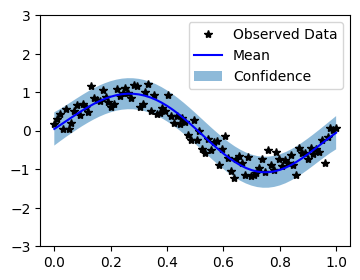

In [36]:
# Plot the Model Fit
with torch.no_grad():
    # Define Plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Obtain Upper and Lower Confidence Bounds
    lcb, ucb = observed_pred.confidence_region()

    # Plot training data (black stars)
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')

    # Plot predictive means (blue line)
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')

    # Shade between LCB, UCB
    ax.fill_between(test_x.numpy(), lcb.numpy(), ucb.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

## GAUCHE Implementation

### Examples

## Implementation Comparison